<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression in PyTorch

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [69]:
import torch
import matplotlib.pyplot as plt

In [70]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [71]:
#y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2) 
#mean=torch.zeros(8) we set to zero so our noise is distributed normally around
#std=0.2 how much noise do we want. if we make larger we get more noise
#we will not run this code because we want to use hard coded fixed y values underneath

For reproducibility of this demo, here's a fixed example of $y$ values obtained by running the commented-out line above: 

In [72]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

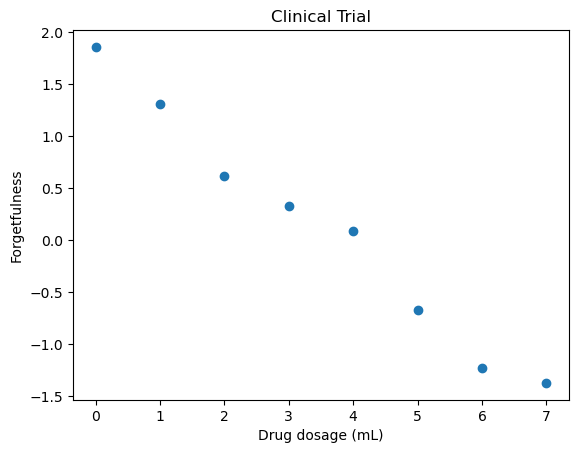

In [73]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

When we randomly initialize the parameters of an ML model, it's typically a good practice to start with near-zero values because values far from zero would imply a strong opinion or that learning had already occurred. 

For the purposes of this toy ML demonstration, we aren't truly initializing with a random value. Instead we're manually selecting a "random" value. You are welcome to choose a different value yourself such as one that approximates the negative slope you can see (however, with real-world ML models, we'd rarely be able to "eyeball" parameter values because there could be millions of them). I deliberately chose starting values that do not look like they would fit the data well right off the bat so that we can clearly observe a model learning.


In [74]:
m = torch.tensor([0.9]).requires_grad_() 
#now when we use our x values and we flow them through functions any other tensors the m tensor comes
#in contact with will also track gradients and that will allows us to apply differentiation back so
#we can find the slope of y in respect to x
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [75]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [76]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [77]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

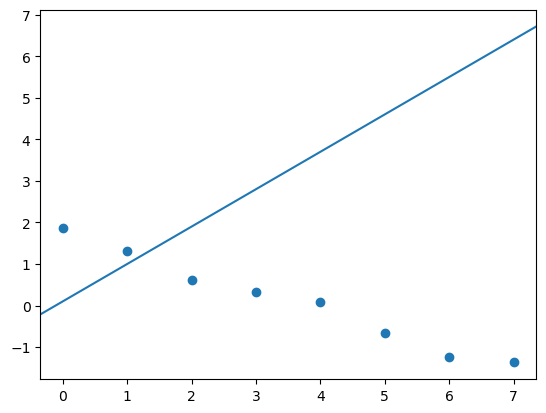

In [78]:
regression_plot(x, y, m, b)

**Return to slides here if following *Calculus I* class.**

### Machine Learning
In four easy steps :)

**Step 1**: Forward pass

In [79]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [81]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [82]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [83]:
C.backward()
#we want to find out what changes we need to make in each of our parameters
#differentiate backwards over the erlier tensors in our graph
#use the chain rule to calculate C with respect to m and b

In [84]:
m.grad

tensor([36.3050])

In [85]:
b.grad

tensor([6.2650])

**Step 4**: Gradient descent

In [88]:
optimizer = torch.optim.SGD([m, b], lr=0.01)
#stohastic gradient descent. We pass a list with all the parameters we want to change
#and for the second argument we add the learning rate. How much we will adjust m and b.
#lr is a hyperparameter

In [89]:
optimizer.step()

Confirm parameters have been adjusted sensibly: 

In [90]:
m

tensor([0.1739], requires_grad=True)

In [91]:
b

tensor([-0.0253], requires_grad=True)

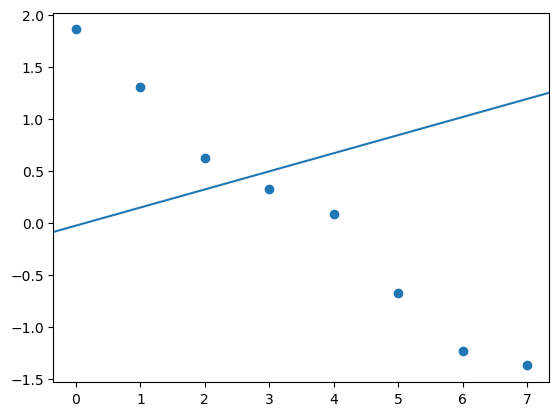

In [92]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has decreased: 

In [93]:
C = mse(regression(x, m, b), y)
C

tensor(2.4083, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost toward zero: 

In [95]:
epochs = 1000
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 0.0195, m grad 0.000665, b grad -0.00327
Epoch 1, cost 0.0195, m grad 0.000661, b grad -0.00325
Epoch 2, cost 0.0195, m grad 0.000657, b grad -0.00323
Epoch 3, cost 0.0195, m grad 0.000653, b grad -0.00321
Epoch 4, cost 0.0195, m grad 0.00065, b grad -0.00319
Epoch 5, cost 0.0195, m grad 0.000646, b grad -0.00318
Epoch 6, cost 0.0195, m grad 0.000642, b grad -0.00316
Epoch 7, cost 0.0195, m grad 0.000639, b grad -0.00314
Epoch 8, cost 0.0195, m grad 0.000635, b grad -0.00312
Epoch 9, cost 0.0195, m grad 0.000631, b grad -0.0031
Epoch 10, cost 0.0195, m grad 0.000627, b grad -0.00309
Epoch 11, cost 0.0195, m grad 0.000624, b grad -0.00307
Epoch 12, cost 0.0195, m grad 0.00062, b grad -0.00305
Epoch 13, cost 0.0195, m grad 0.000616, b grad -0.00303
Epoch 14, cost 0.0195, m grad 0.000613, b grad -0.00302
Epoch 15, cost 0.0195, m grad 0.000609, b grad -0.003
Epoch 16, cost 0.0195, m grad 0.000605, b grad -0.00298
Epoch 17, cost 0.0195, m grad 0.000602, b grad -0.00296
Epoch 1

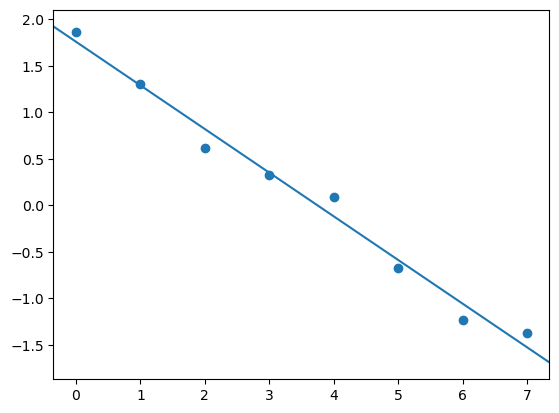

In [96]:
regression_plot(x, y, m, b)

In [97]:
m.item()

-0.4692818522453308

In [98]:
b.item()

1.7599809169769287

**N.B.**: The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be. 